# Projeto facerecog

In [1]:
%%writefile requirements.txt

# lista extensa do environment, depois filtro para os que foram utilizados realmente
ipython==5.1.0
ipython-genutils==0.1.0
ipywidgets==5.2.2
jupyter-client==4.4.0
jupyter-core==4.2.0
matplotlib==1.5.3
notebook==4.2.2
numpy==1.11.1
pandas==0.18.1
Pillow==3.3.1
pytesseract==0.1.6
scikit-image==0.12.3
seaborn==0.7.1

# the following must be installed separately
# opencv==3.1.0
# tesseract

Overwriting requirements.txt


In [2]:
# uncomment line below to install requirements (recommended to use a virtualenv)
#!pip install -r requirements.txt

-----------------------

# Importação de pacotes

In [3]:
%matplotlib inline
""" handling files support packages """
from glob import glob

""" logic support packages """
import numpy as np
import pytesseract

""" plot support packages """
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

""" image trasformation packages """
from PIL import Image
import skimage.io as skio
from skimage.util import dtype_limits
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.filters import rank
from skimage.measure import compare_ssim as ssim

""" statistical data visualization packages"""
import seaborn as sns

""" seaborn configurations """
sns.set_style('white')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = 20, 10

---------------------------

# Funções de suporte

In [4]:
def plot_captchas(imgs, grid=(5, 4)):
    gs = gridspec.GridSpec(*grid)
    for idx, gspec in enumerate(gs):
        ax = plt.subplot(gspec)
        plt.imshow(imgs[idx])

In [5]:
def save_images(letter_dict):
    i=0
    
    with open('../letras.csv', 'a+') as f:
        f.write("path, rotulo, caixa_alta_baixa\n")
        
    for letra in letter_dict:
        for imagem in letter_dict[letra]:
            im = Image.fromarray(imagem)
            im.save("../letras/caracter" + str(i) + ".png")
            with open('../letras.csv', 'a+') as f:
                if letra.istitle():
                    f.write("letras/caracter" + str(i) + ".png, " + letra + ", maiusculo\n")
                else:
                    if letra.isdigit():
                        f.write("letras/caracter" + str(i) + ".png, " + letra + ", numero\n")
                    else:
                        f.write("letras/caracter" + str(i) + ".png, " + letra + ", minusculo\n")
            i = i + 1

In [6]:
def get_char(img, n_char):
    sw = {
        0: {'x1': 0, 'x2': 50, 'y1': 5, 'y2': 40},
        1: {'x1': 0, 'x2': 50, 'y1': 35, 'y2': 70},
        2: {'x1': 0, 'x2': 50, 'y1': 65, 'y2': 100},
        3: {'x1': 0, 'x2': 50, 'y1': 95, 'y2': 130},
        4: {'x1': 0, 'x2': 50, 'y1': 123, 'y2': 158},
        5: {'x1': 0, 'x2': 50, 'y1': 155, 'y2': 190},
    }
    return img[sw[n_char]['x1']:sw[n_char]['x2'], sw[n_char]['y1']:sw[n_char]['y2']]

In [7]:
def feed_char_dict(char_dict, letter_array, imgs):
    for letter, img in zip(letter_array, imgs):
    
        if letter in char_dict:
            char_dict[letter].append(img)
        else:
            char_dict[letter] = [img]

-----------------------------

## Filtro nas imagens

In [8]:
def remove_small_blobs(bw_img, min_area=10, **label_kwargs):
    """ Remove small blobs in the bw img. """
    labels = label(bw_img, **label_kwargs)

    # pick the background and foreground colors
    bg = label_kwargs.get('background', 0) 
    fg = dtype_limits(bw_img, clip_negative=True)[1] - bg

    # create an empty image
    new_bw = np.ones_like(bw_img) * bg
    
    # check the area of each region
    for roi in regionprops(labels):
        if roi.area >= min_area:
            new_bw[labels == roi.label] = fg

    return new_bw

---------------------------

## Teste do PyTesseract

In [9]:
def run_tesseract(imgs):
    for img in imgs:
        img = Image.fromarray( img )
        print( pytesseract.image_to_string( img ) )

--------------------

## Funções de comparação entre imagens

In [10]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [11]:
def compare_images(imageA, imageB, title, channel=True):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=channel)
 
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

----------------------------

# Leitura das imagens iniciais funções de suporte

In [12]:
img_files = sorted(glob('../imagens/captcha*.png'))
print(img_files)
imgs = skio.imread_collection(img_files)
print(imgs.files)

['../imagens/captcha1.png', '../imagens/captcha10.png', '../imagens/captcha11.png', '../imagens/captcha12.png', '../imagens/captcha13.png', '../imagens/captcha14.png', '../imagens/captcha15.png', '../imagens/captcha16.png', '../imagens/captcha17.png', '../imagens/captcha18.png', '../imagens/captcha19.png', '../imagens/captcha2.png', '../imagens/captcha20.png', '../imagens/captcha3.png', '../imagens/captcha4.png', '../imagens/captcha5.png', '../imagens/captcha6.png', '../imagens/captcha7.png', '../imagens/captcha8.png', '../imagens/captcha9.png']
['../imagens/captcha1.png', '../imagens/captcha10.png', '../imagens/captcha11.png', '../imagens/captcha12.png', '../imagens/captcha13.png', '../imagens/captcha14.png', '../imagens/captcha15.png', '../imagens/captcha16.png', '../imagens/captcha17.png', '../imagens/captcha18.png', '../imagens/captcha19.png', '../imagens/captcha2.png', '../imagens/captcha20.png', '../imagens/captcha3.png', '../imagens/captcha4.png', '../imagens/captcha5.png', '../

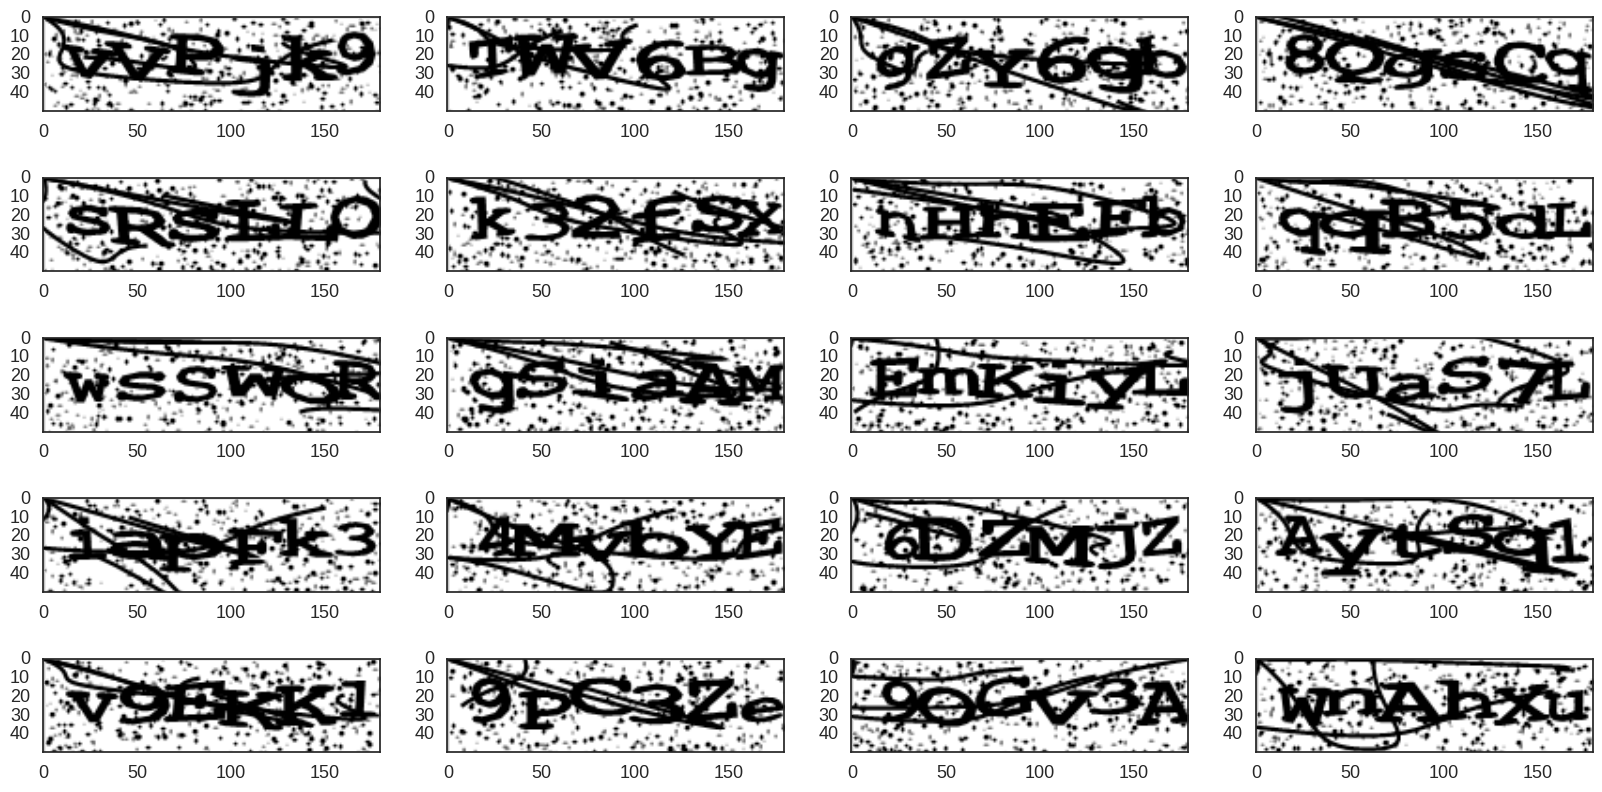

In [13]:
plot_captchas(imgs)

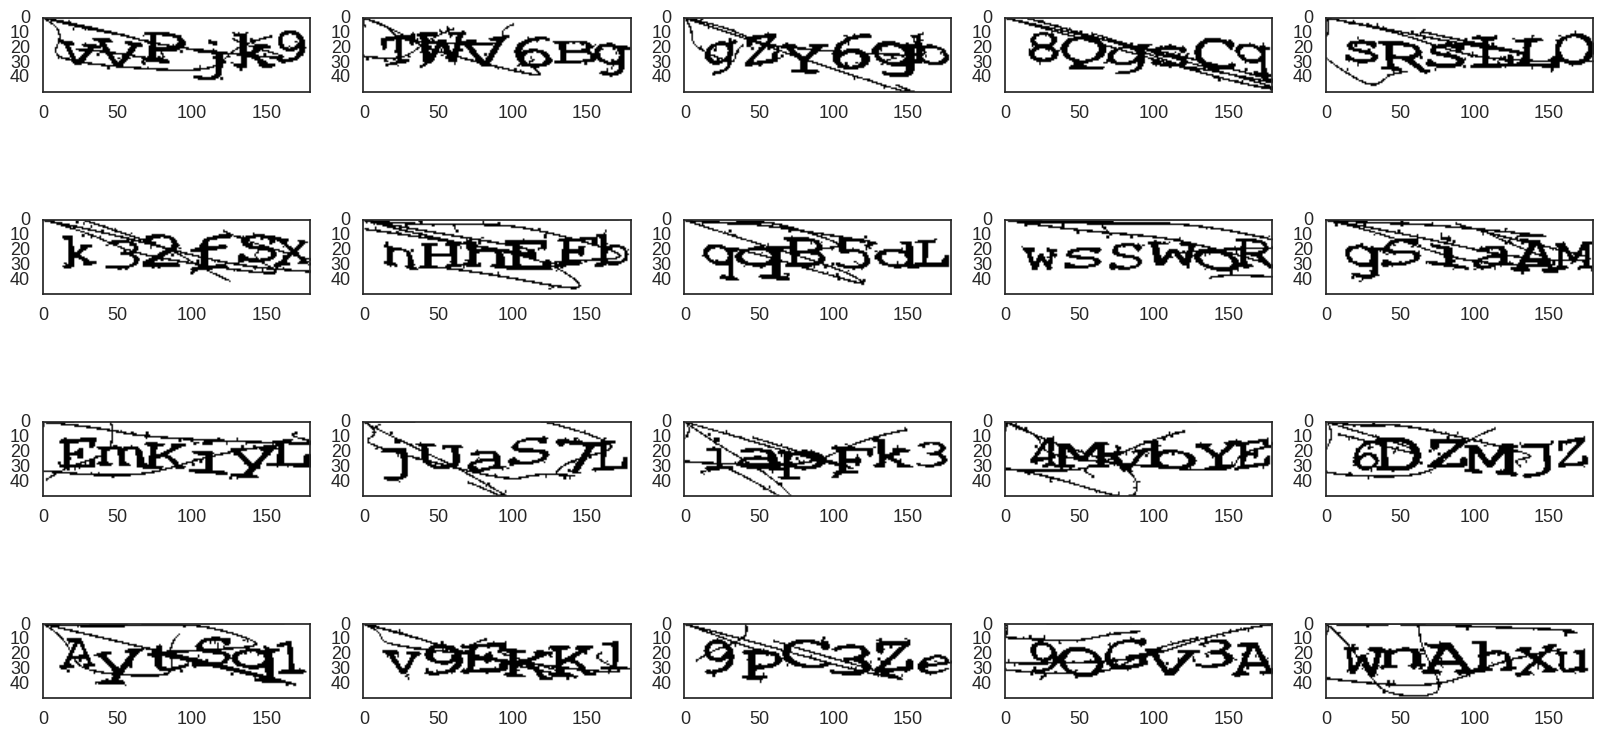

In [14]:
unblobbed = [remove_small_blobs(img, min_area=50, background=255) for img in imgs]
plot_captchas(unblobbed, (4, 5))

------------------------

# Extração e arquivo das letras dos primeiros captchas

In [15]:
captcha_letters = dict()
captcha_letters.clear()
print(captcha_letters == {})

True


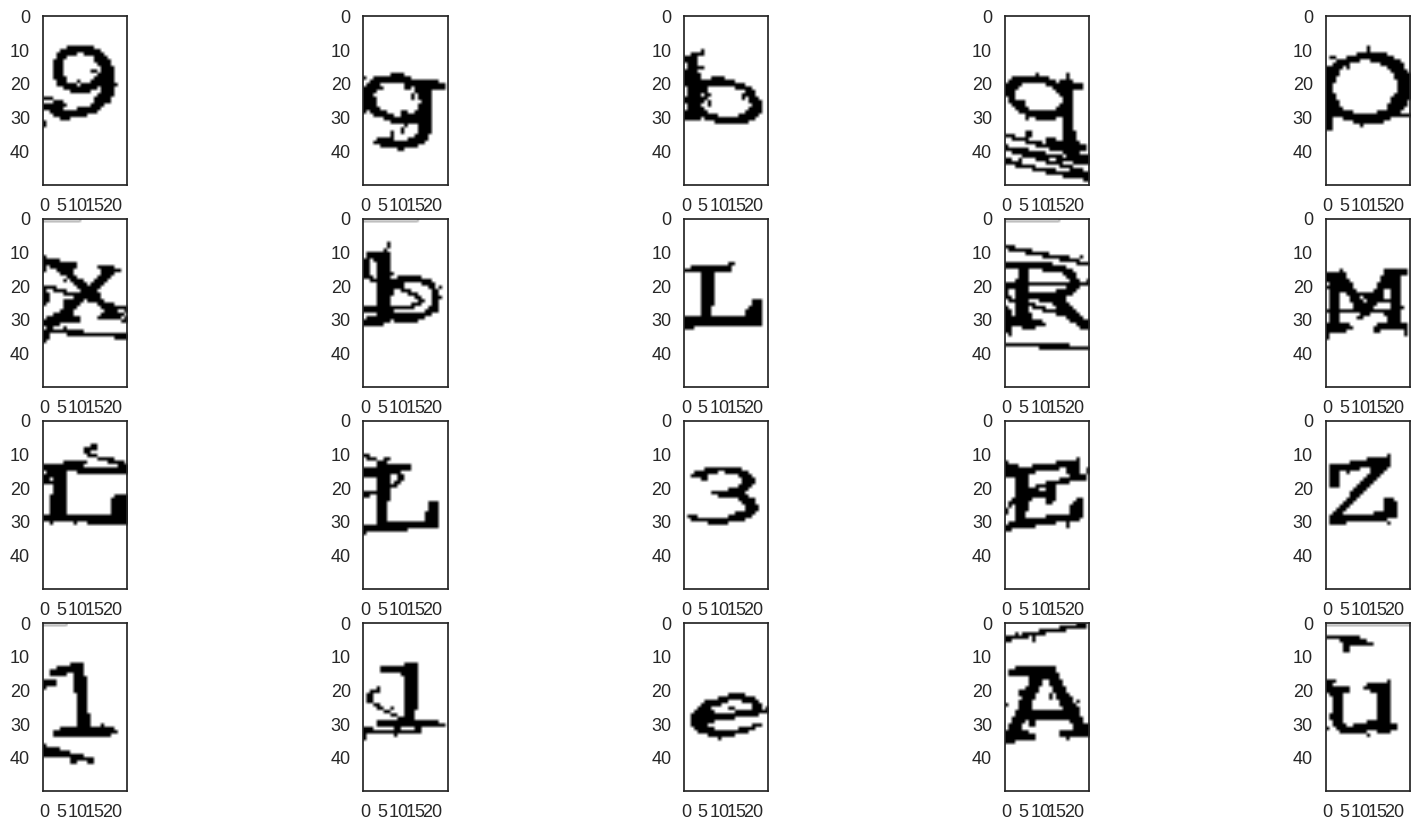

In [16]:
# 6º caractere
cropped = [get_char(img, 5) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [17]:
letters = ('9', 'g', 'b', 'q', 'O',
           'x', 'b', 'L', 'R', 'M',
           'L', 'L', '3', 'E', 'Z',
           '1', '1', 'e', 'A', 'u')

feed_char_dict(captcha_letters, letters, cropped)

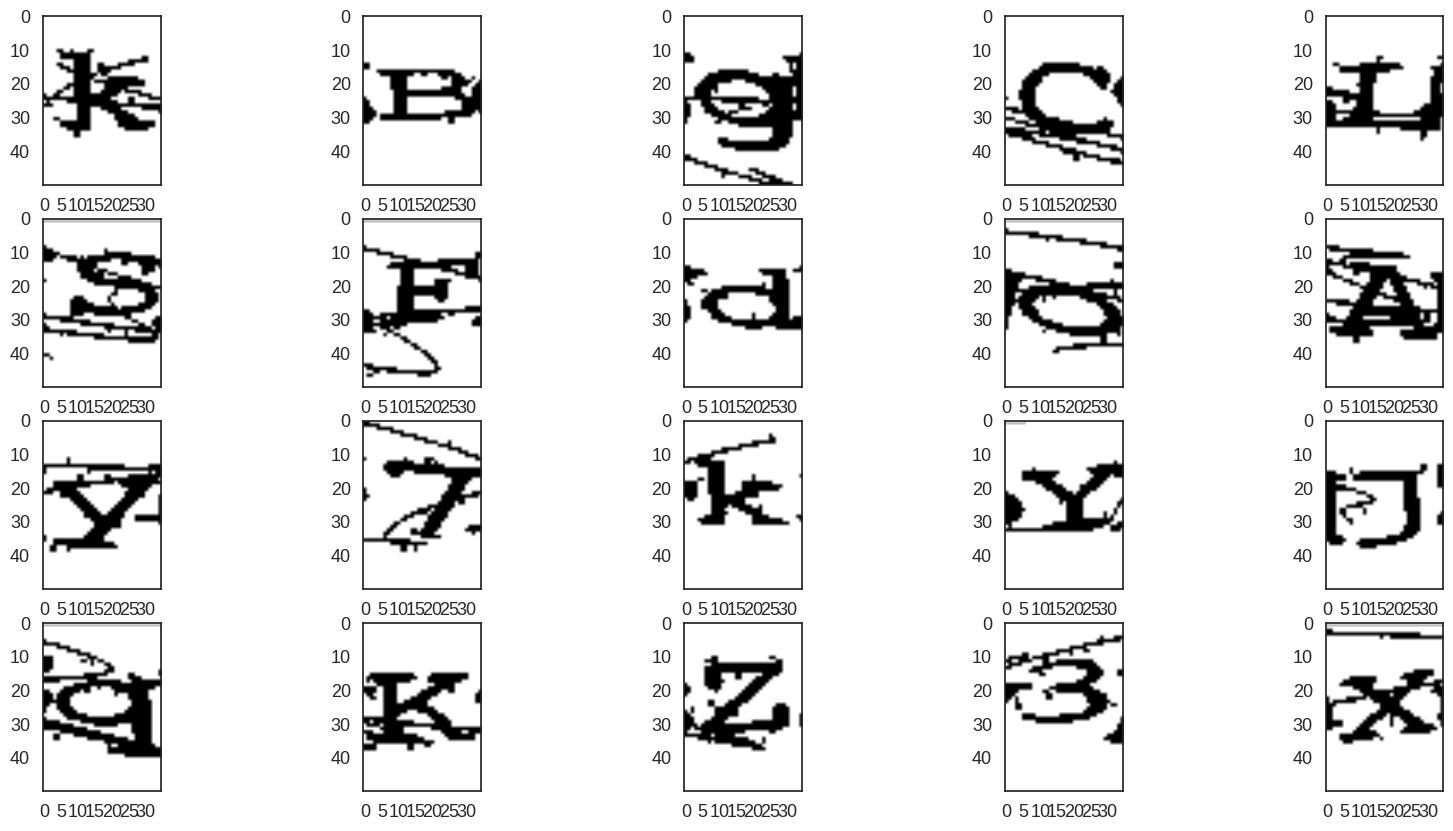

In [18]:
# 5º caractere
cropped = [get_char(img, 4) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [19]:
letters = ('k', 'b', 'g', 'c', 'L',
           'S', 'F', 'd', 'o', 'A',
           'y', '7', 'k', 'Y', 'J',
           'q', 'K', 'Z', '3', 'X')

feed_char_dict(captcha_letters, letters, cropped)

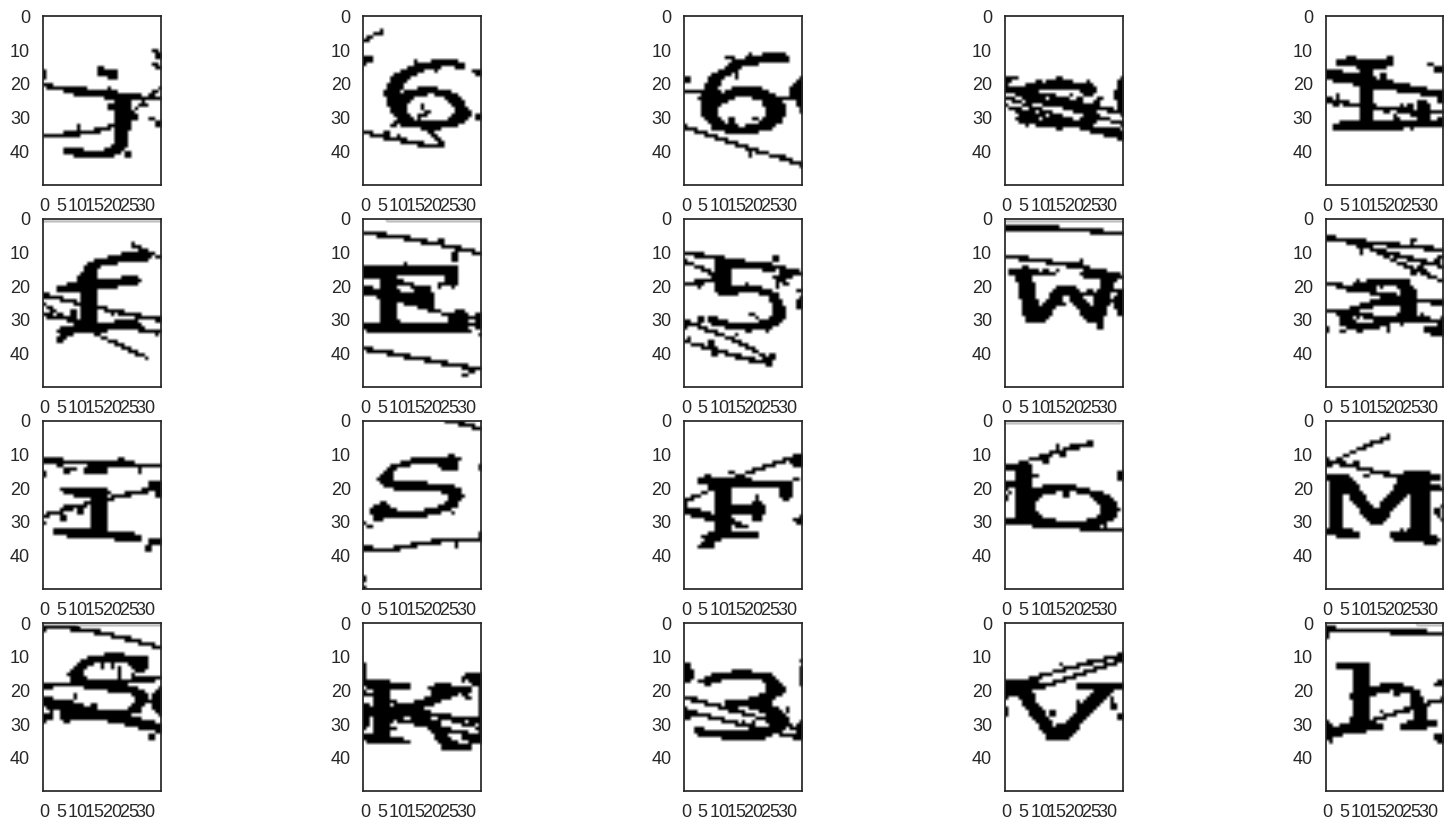

In [20]:
# 4º caractere
cropped = [get_char(img, 3) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [21]:
letters = ('j', '6', '6', 's', 'L',
           'f', 'E', '5', 'W', 'a',
           'i', 'S', 'F', 'b', 'M',
           'S', 'K', '3', 'V', 'h')

feed_char_dict(captcha_letters, letters, cropped)

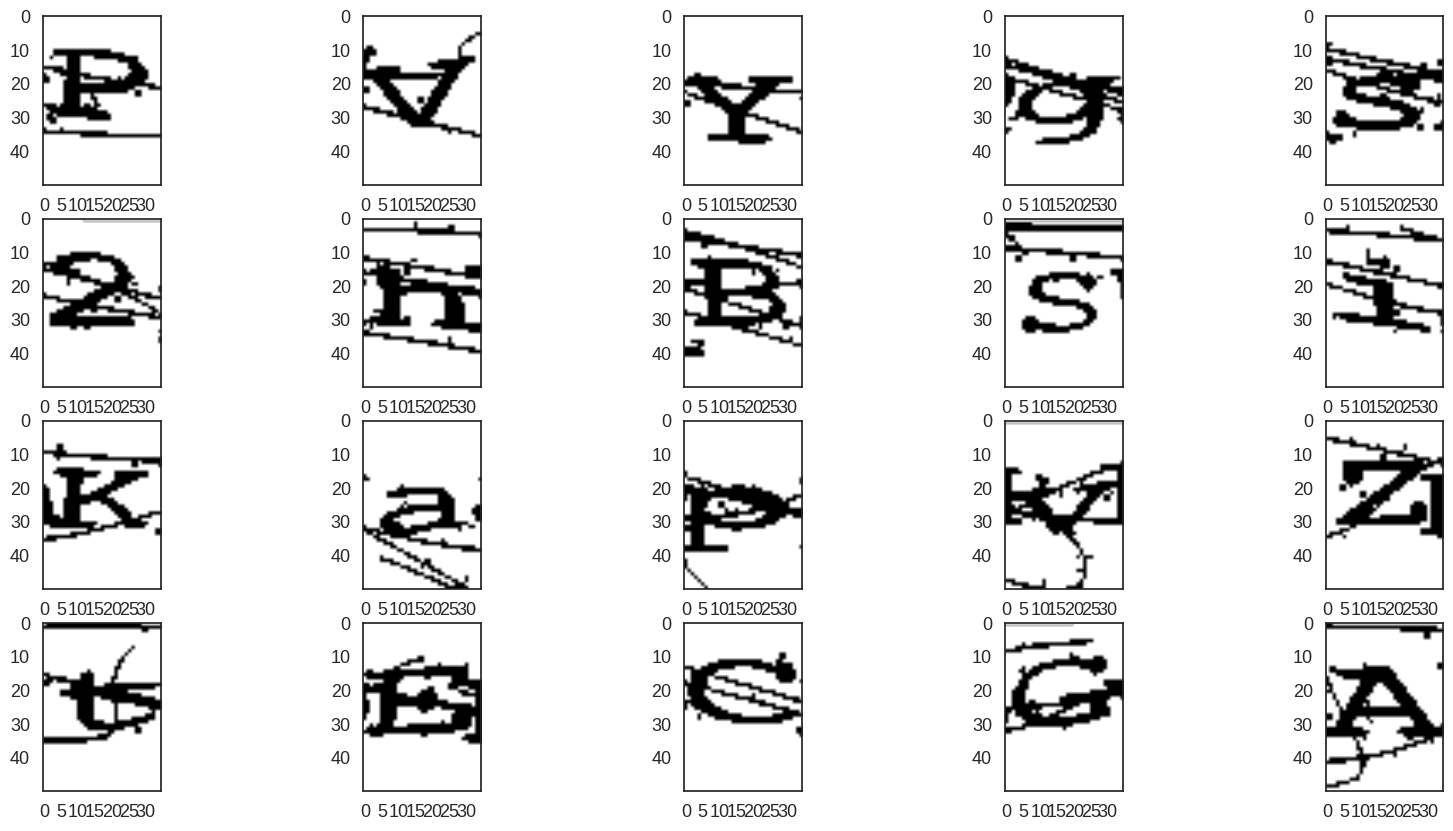

In [22]:
# 3º caractere
cropped = [get_char(img, 2) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [23]:
letters = ('P', 'V', 'Y', 'g', 's',
           '2', 'n', 'B', 's', 'i',
           'K', 'a', 'p', 'v', 'Z',
           't', 'E', 'C', 'G', 'A')

feed_char_dict(captcha_letters, letters, cropped)

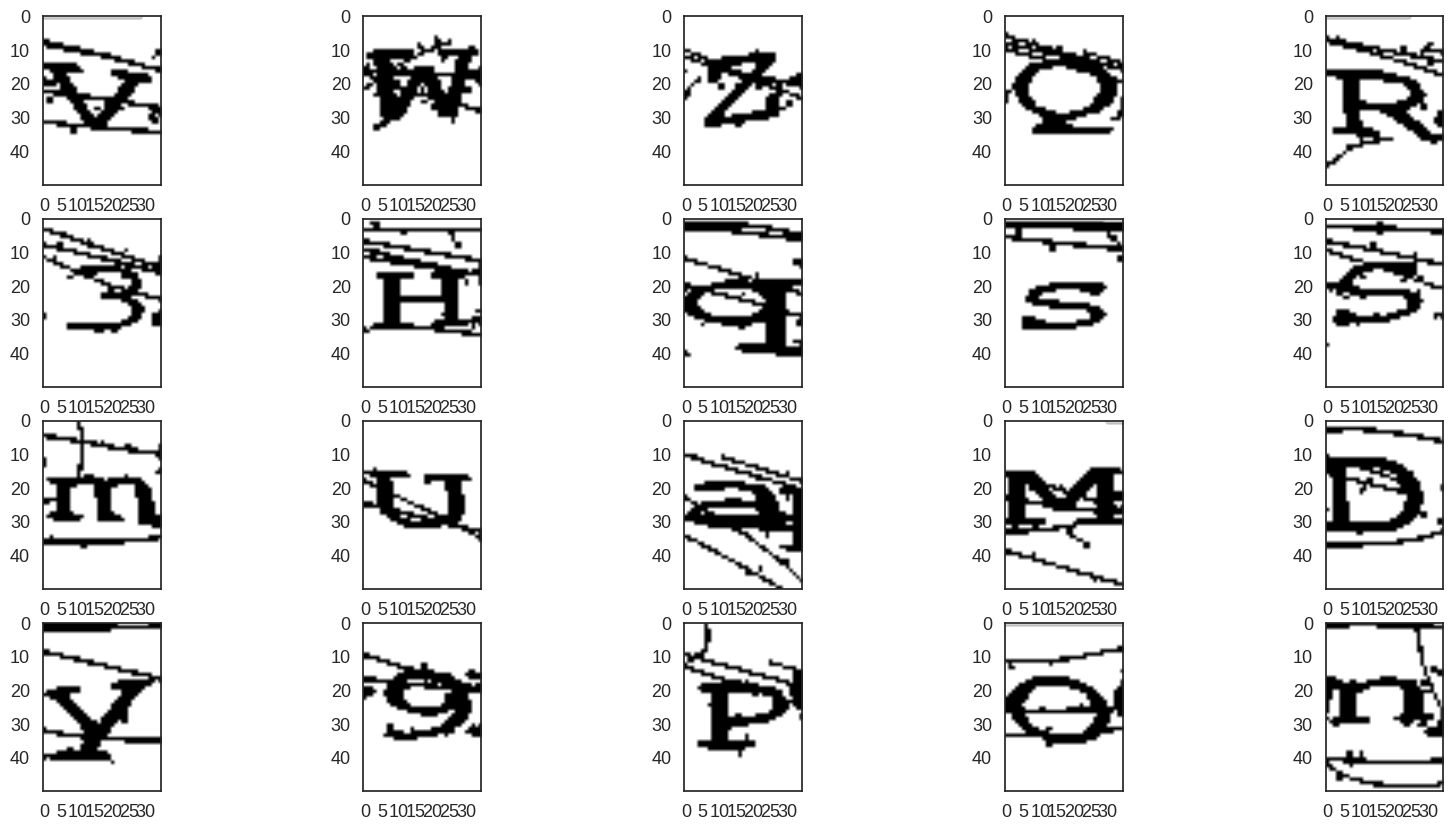

In [24]:
# 2º caractere
cropped = [get_char(img, 1) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [25]:
letters = ('V', 'W', 'Z', 'Q', 'R',
           '3', 'H', 'q', 's', 'S',
           'm', 'u', 'a', 'M', 'D',
           'y', '9', 'p', 'o', 'n')

feed_char_dict(captcha_letters, letters, cropped)

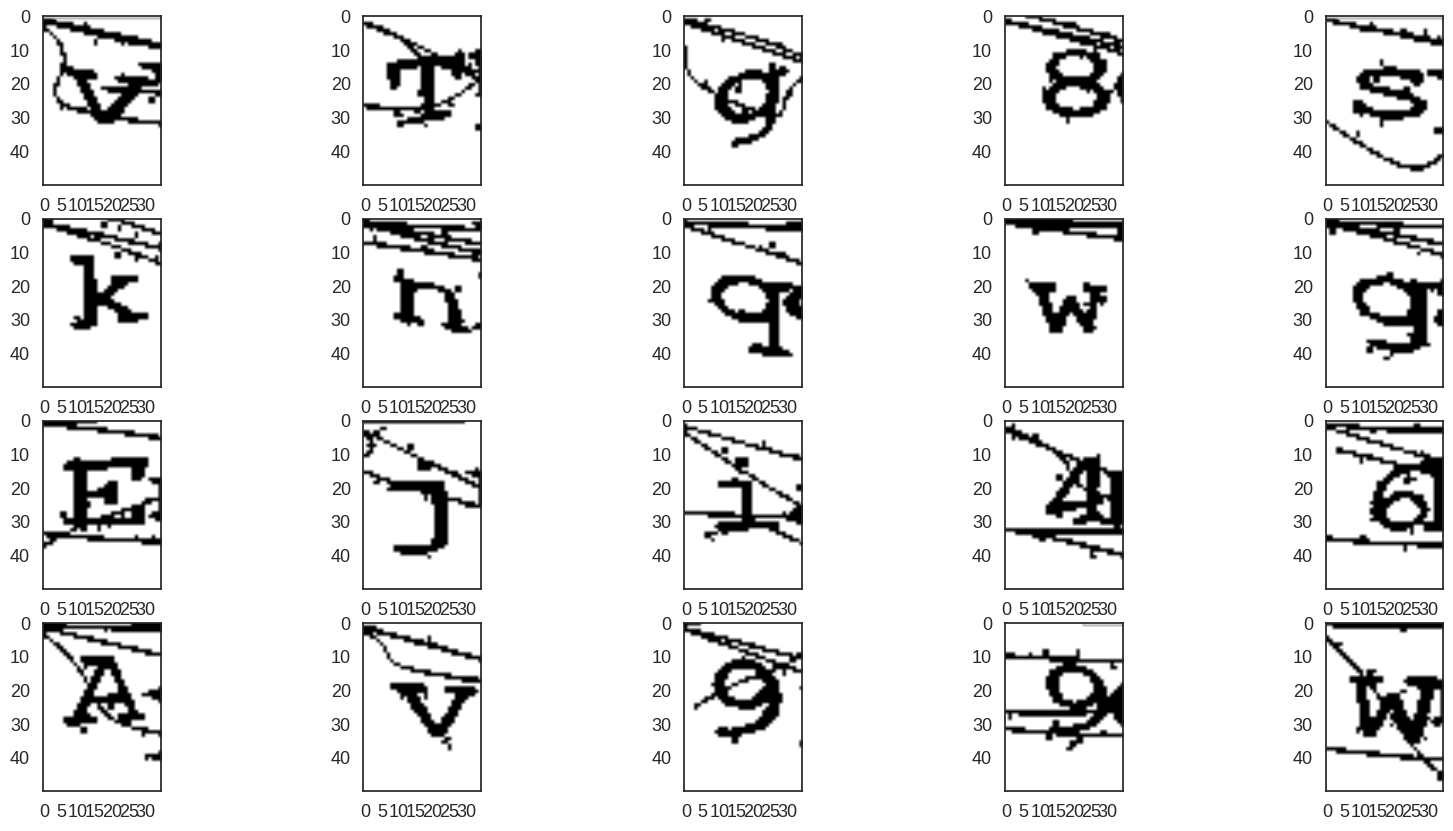

In [26]:
# 1º caractere
cropped = [get_char(img, 0) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [27]:
letters = ('v', 'T', 'g', '8', 's',
           'k', 'n', 'q', 'w', 'g',
           'E', 'j', 'i', '4', '6',
           'A', 'v', '9', '9', 'W')

feed_char_dict(captcha_letters, letters, cropped)

----------

# Inclusão dos novos captchas

À partir daqui farei a inclusão dos novos captchas no dicionário já criado **captcha_letters**:

In [28]:
img_files = sorted(glob('../imagens/gerarCaptcha.asp*.png'))
print(img_files)
imgs = skio.imread_collection(img_files)

['../imagens/gerarCaptcha.asp.png', '../imagens/gerarCaptcha.asp1.png', '../imagens/gerarCaptcha.asp10.png', '../imagens/gerarCaptcha.asp11.png', '../imagens/gerarCaptcha.asp12.png', '../imagens/gerarCaptcha.asp13.png', '../imagens/gerarCaptcha.asp14.png', '../imagens/gerarCaptcha.asp15.png', '../imagens/gerarCaptcha.asp16.png', '../imagens/gerarCaptcha.asp17.png', '../imagens/gerarCaptcha.asp18.png', '../imagens/gerarCaptcha.asp19.png', '../imagens/gerarCaptcha.asp2.png', '../imagens/gerarCaptcha.asp20.png', '../imagens/gerarCaptcha.asp21.png', '../imagens/gerarCaptcha.asp22.png', '../imagens/gerarCaptcha.asp23.png', '../imagens/gerarCaptcha.asp24.png', '../imagens/gerarCaptcha.asp25.png', '../imagens/gerarCaptcha.asp26.png', '../imagens/gerarCaptcha.asp27.png', '../imagens/gerarCaptcha.asp28.png', '../imagens/gerarCaptcha.asp29.png', '../imagens/gerarCaptcha.asp3.png', '../imagens/gerarCaptcha.asp30.png', '../imagens/gerarCaptcha.asp31.png', '../imagens/gerarCaptcha.asp32.png', '../i

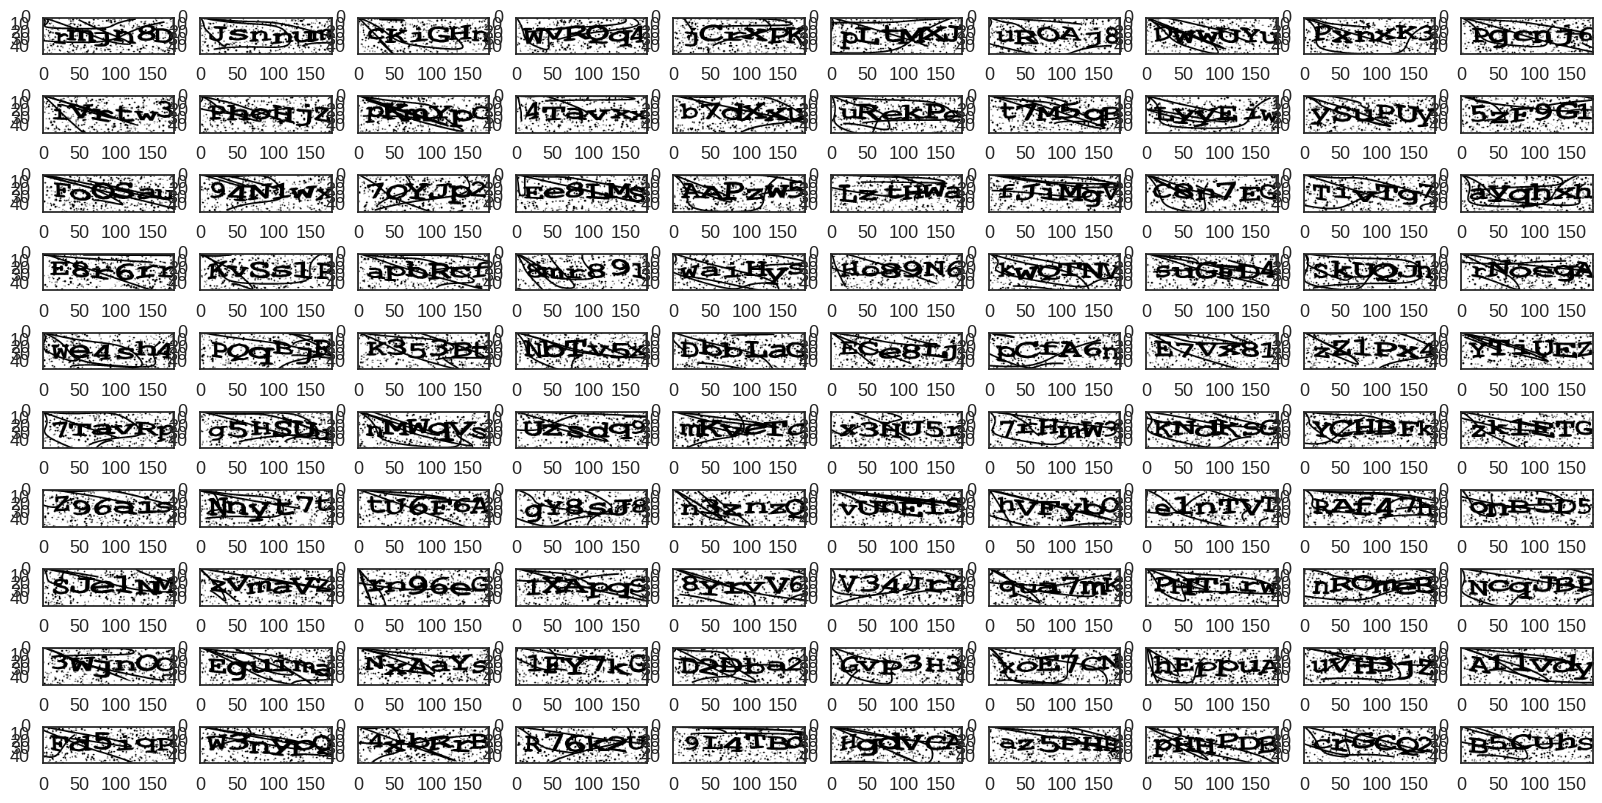

In [29]:
plot_captchas(imgs, (10, 10))

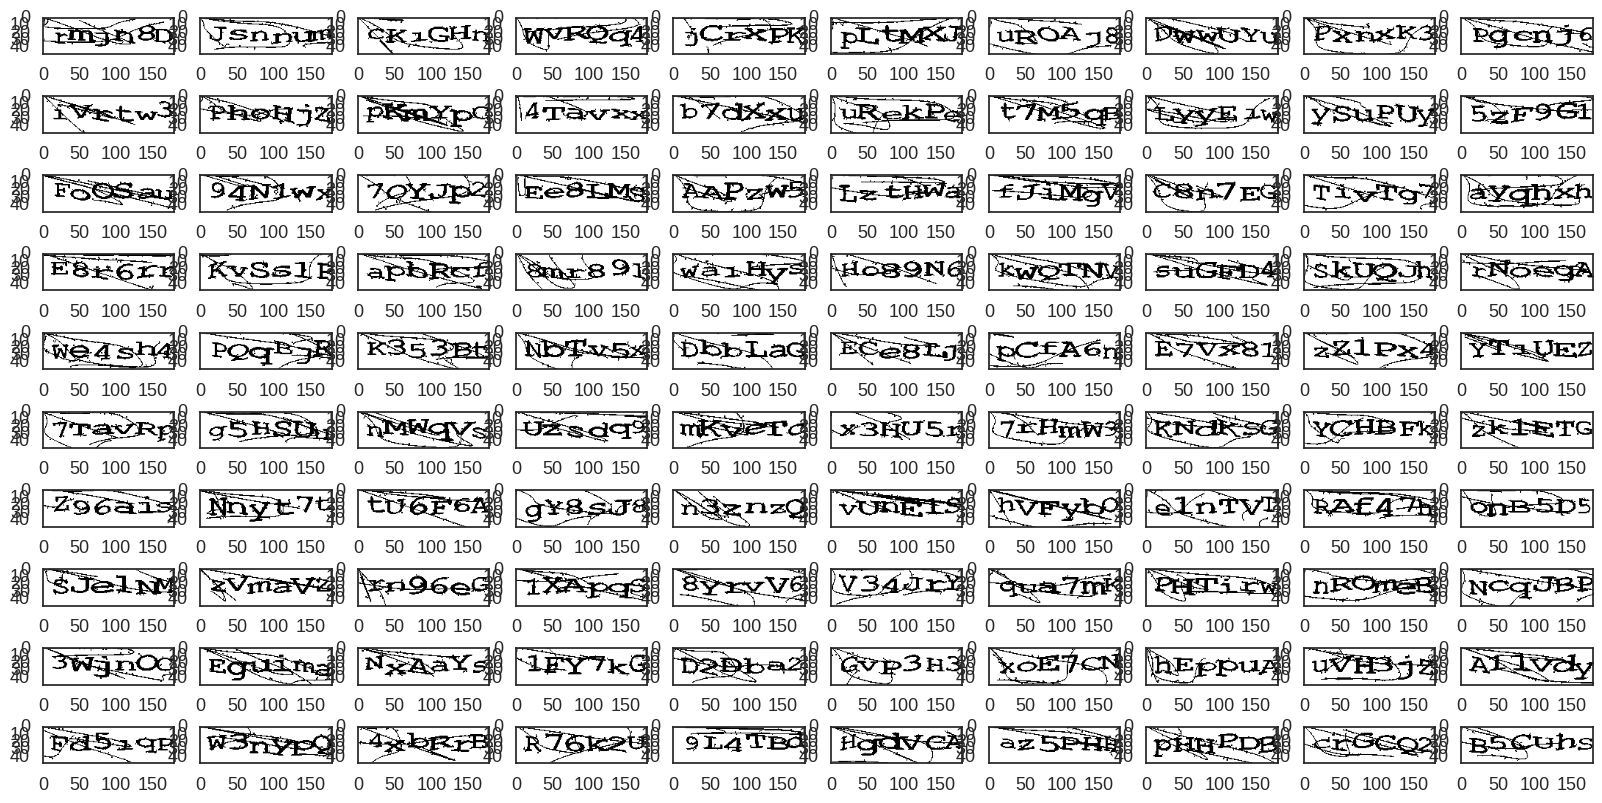

In [30]:
unblobbed = [remove_small_blobs(img, min_area=50, background=255) for img in imgs]
plot_captchas(unblobbed, (10, 10))

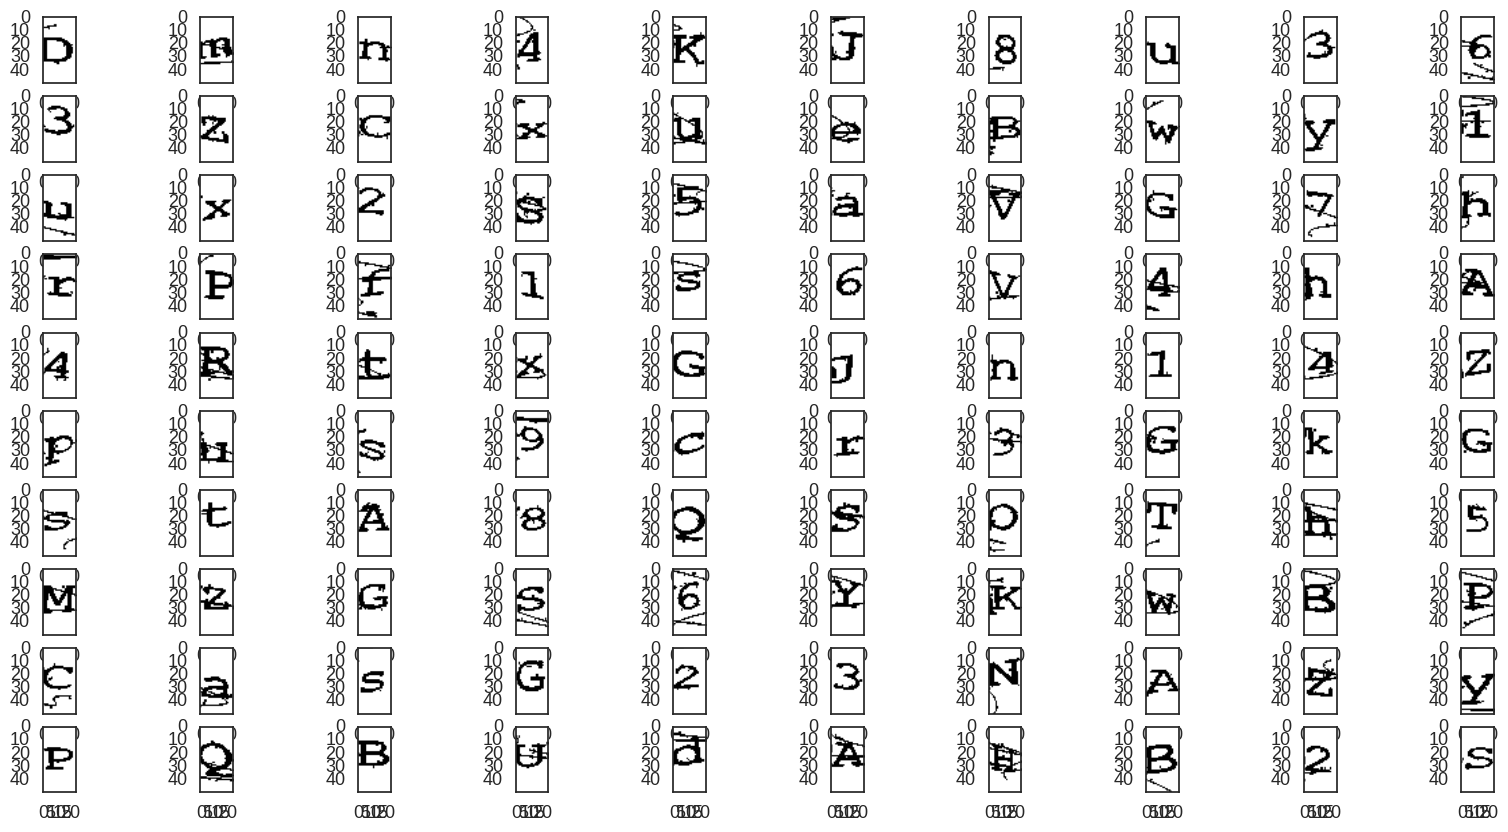

In [31]:
# 6º caractere
cropped = [get_char(img, 5) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [32]:
letters = ('D', 'M', 'n', '4', 'K', 'J', '8', 'u', '3', '6',
            '3', 'z', 'c', 'x', 'u', 'e', 'B', 'w', 'y', '1',
            'u', 'x', '2', 's', '5', 'a', 'V', 'G', '7', 'h',
            'r', 'P', 'f', '1', 's', '6', 'V', '4', 'h', 'A',
            '4', 'R', 't', 'x', 'G', 'j', 'n', '1', '4', 'Z',
            'p', 'u', 's', '9', 'c', 'r', '3', 'G', 'k', 'G',
            's', 't', 'A', '8', 'Q', 'S', 'O', 'T', 'h', '5',
            'M', 'z', 'G', 's', '6', 'Y', 'K', 'w', 'B', 'P',
            'C', 'a', 's', 'G', '2', '3', 'N', 'A', 'Z', 'y',
            'p', 'Q', 'B', 'U', 'd', 'A', 'H', 'B', '2', 's')

feed_char_dict(captcha_letters, letters, cropped)

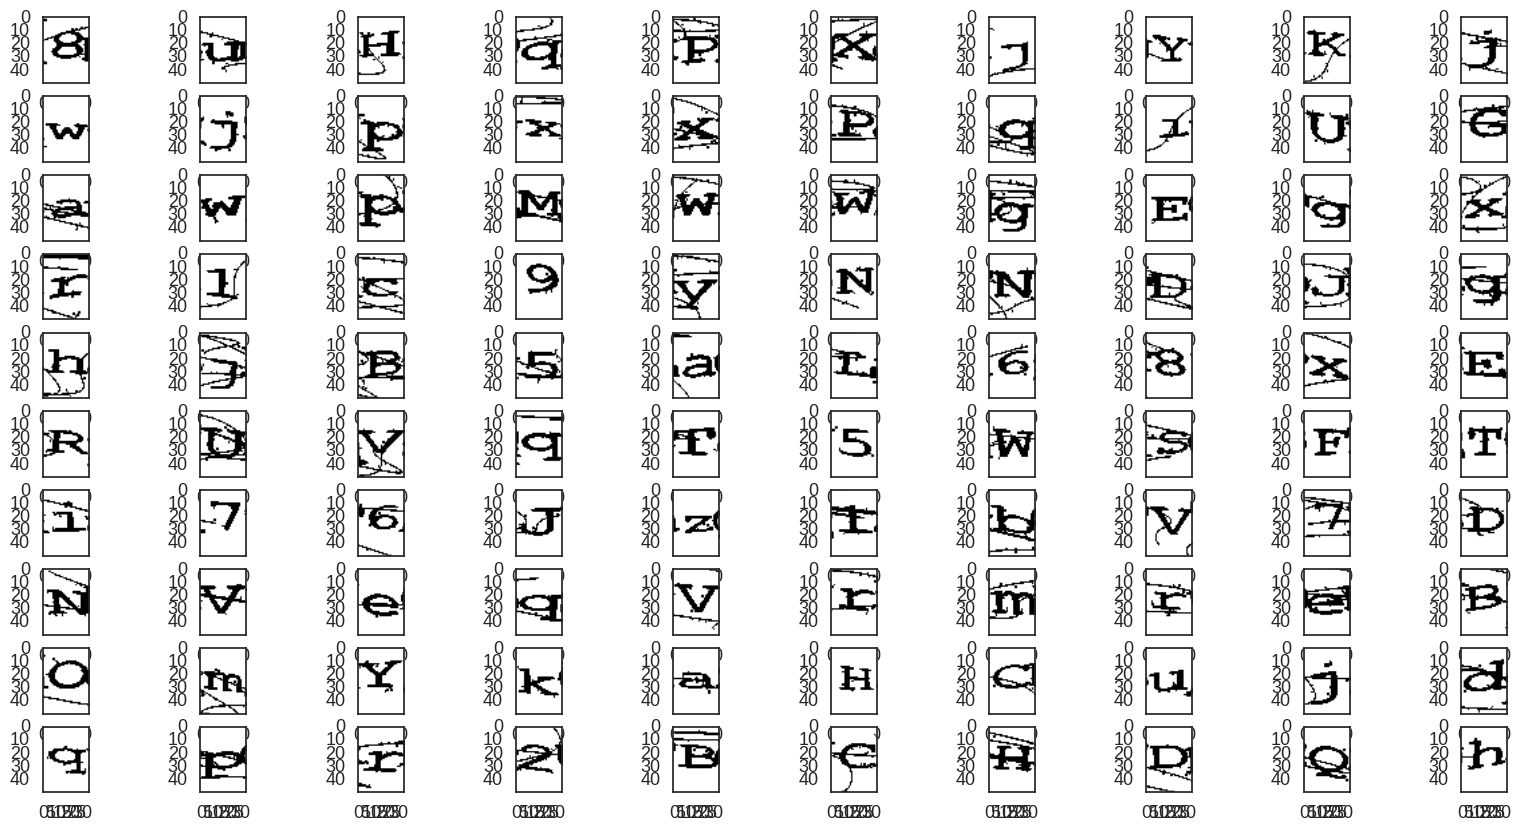

In [33]:
# 5º caractere
cropped = [get_char(img, 4) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [34]:
letters = ('8', 'u', 'H', 'q', 'P', 'X', 'j', 'Y', 'K', 'j',
            'w', 'j', 'p', 'x', 'x', 'P', 'q', '1', 'U', 'G',
            'a', 'w', 'p', 'M', 'w', 'w', 'g', 'E', 'g', 'x',
            'r', '1', 'c', '9', 'y', 'N', 'N', 'D', 'J', 'g',
            'h', 'j', 'B', '5', 'a', 'L', '6', '8', 'x', 'E',
            'R', 'U', 'V', 'q', 'T', '5', 'W', 's', 'F', 'T',
            'i', '7', '6', 'J', 'z', '1', 'b', 'V', '7', 'D',
            'N', 'V', 'e', 'q', 'V', 'r', 'm', 'r', 'e', 'B',
            'O', 'm', 'Y', 'k', 'a', 'H', 'C', 'u', 'j', 'd',
            'q', 'p', 'r', '2', 'B', 'c', 'H', 'D', 'Q', 'h')

feed_char_dict(captcha_letters, letters, cropped)

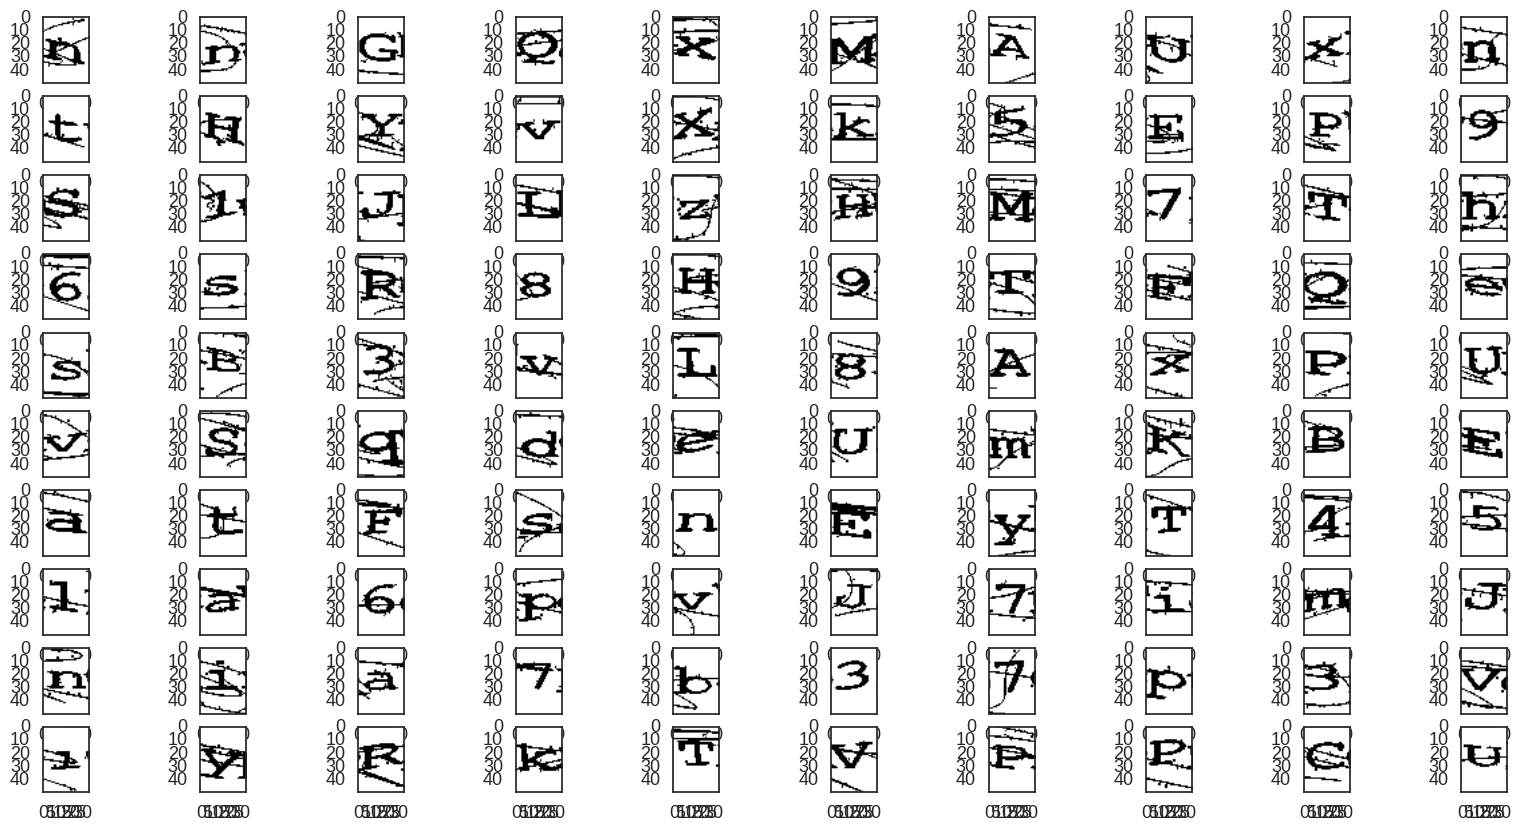

In [35]:
# 4º caractere
cropped = [get_char(img, 3) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [36]:
letters = ('n', 'n', 'G', 'Q', 'x', 'M', 'A', 'U', 'x', 'n',
            't', 'H', 'Y', 'v', 'X', 'k', '5', 'E', 'P', '9',
            'S', '1', 'J', 'L', 'z', 'H', 'M', '7', 'T', 'h',
            '6', 's', 'R', '8', 'H', '9', 'T', 'F', 'Q', 'e',
            's', 'B', '3', 'v', 'L', '8', 'A', 'x', 'P', 'U',
            'v', 'S', 'q', 'd', 'e', 'U', 'm', 'K', 'B', 'E',
            'a', 't', 'F', 's', 'n', 'E', 'y', 'T', '4', '5',
            'l', 'a', '6', 'p', 'v', 'J', '7', 'i', 'm', 'J',
            'n', 'i', 'a', '7', 'b', '3', '7', 'p', '3', 'v',
            '1', 'y', 'R', 'k', 'T', 'V', 'p', 'p', 'C', 'u')

feed_char_dict(captcha_letters, letters, cropped)

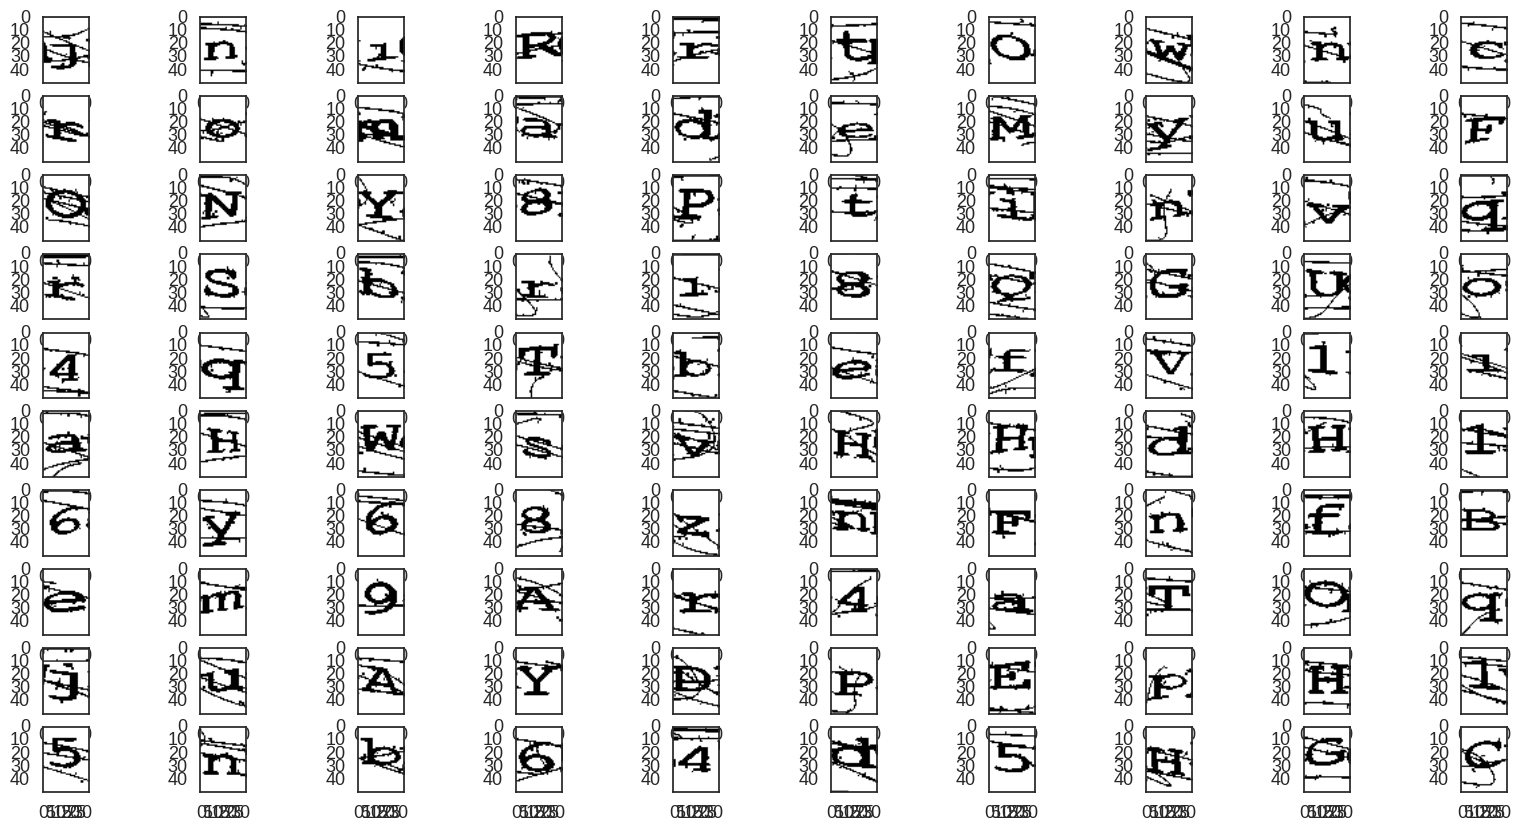

In [37]:
# 3º caractere
cropped = [get_char(img, 2) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [38]:
letters = ('j', 'n', '1', 'R', 'r', 't', 'O', 'w', 'n', 'c',
          'r', 'o', 'm', 'a', 'd', 'e', 'M', 'y', 'u', 'F',
          'O', 'N', 'Y', '8', 'P', 't', 'i', 'n', 'v', 'q',
          'r', 'S', 'b', 'r', '1', '8', 'Q', 'G', 'U', 'o',
          '4', 'q', '5', 'T', 'b', 'e', 'f', 'V', '1', '1',
          'a', 'H', 'W', 's', 'v', 'H', 'H', 'd', 'H', '1',
          '6', 'y', '6', '8', 'z', 'n', 'F', 'n', 'f', 'B',
          'e', 'm', '9', 'A', 'r', '4', 'a', 'T', 'O', 'q',
          'j', 'u', 'A', 'Y', 'D', 'p', 'E', 'p', 'H', '1',
          '5', 'n', 'b', '6', '4', 'd', '5', 'H', 'G', 'c')

feed_char_dict(captcha_letters, letters, cropped)

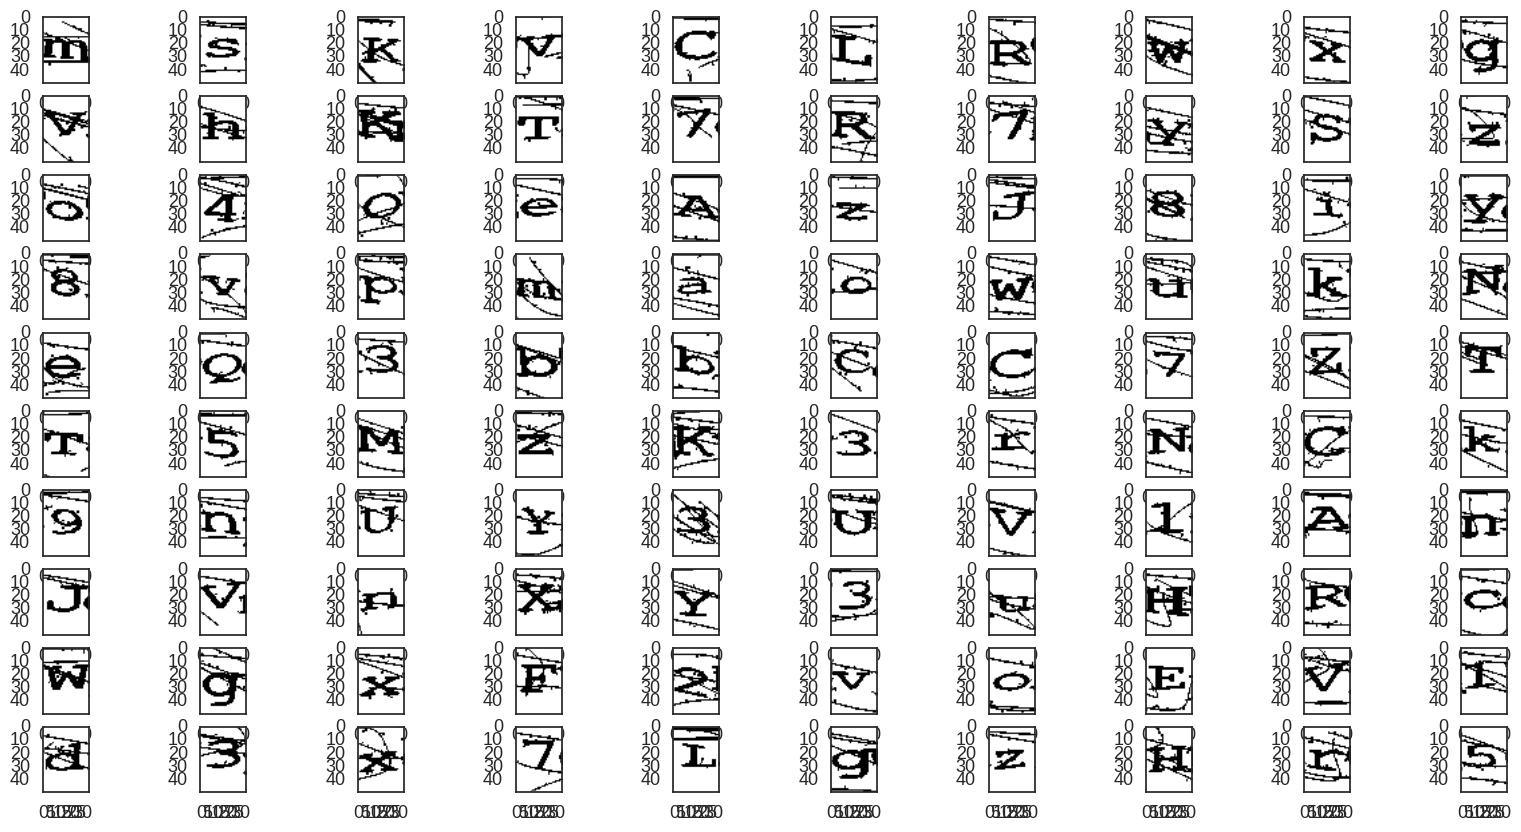

In [39]:
# 2º caractere

cropped = [get_char(img, 1) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [40]:
letters = ('m', 's', 'K', 'v', 'C', 'L', 'R', 'w', 'x', 'g',
          'v', 'h', 'K', 'T', '7', 'R', '7', 'Y', 'S', 'z',
          'o', '4', 'o', 'e', 'A', 'z', 'J', '8', 'i', 'y',
          '8', 'v', 'p', 'm', 'a', 'o', 'w', 'u', 'k', 'N',
          'e', 'Q', '3', 'b', 'b', 'c', 'C', '7', 'z', 'T',
          'T', '5', 'M', 'z', 'K', '3', 'r', 'N', 'C', 'k',
          '9', 'n', 'U', 'Y', '3', 'U', 'V', '1', 'A', 'n',
          'J', 'V', 'n', 'X', 'Y', '3', 'u', 'H', 'R', 'c',
          'W', 'g', 'x', 'F', '2', 'v', 'o', 'E', 'V', '1',
          'd', '3', 'x', '7', 'L', 'g', 'z', 'H', 'r', 's')

feed_char_dict(captcha_letters, letters, cropped)

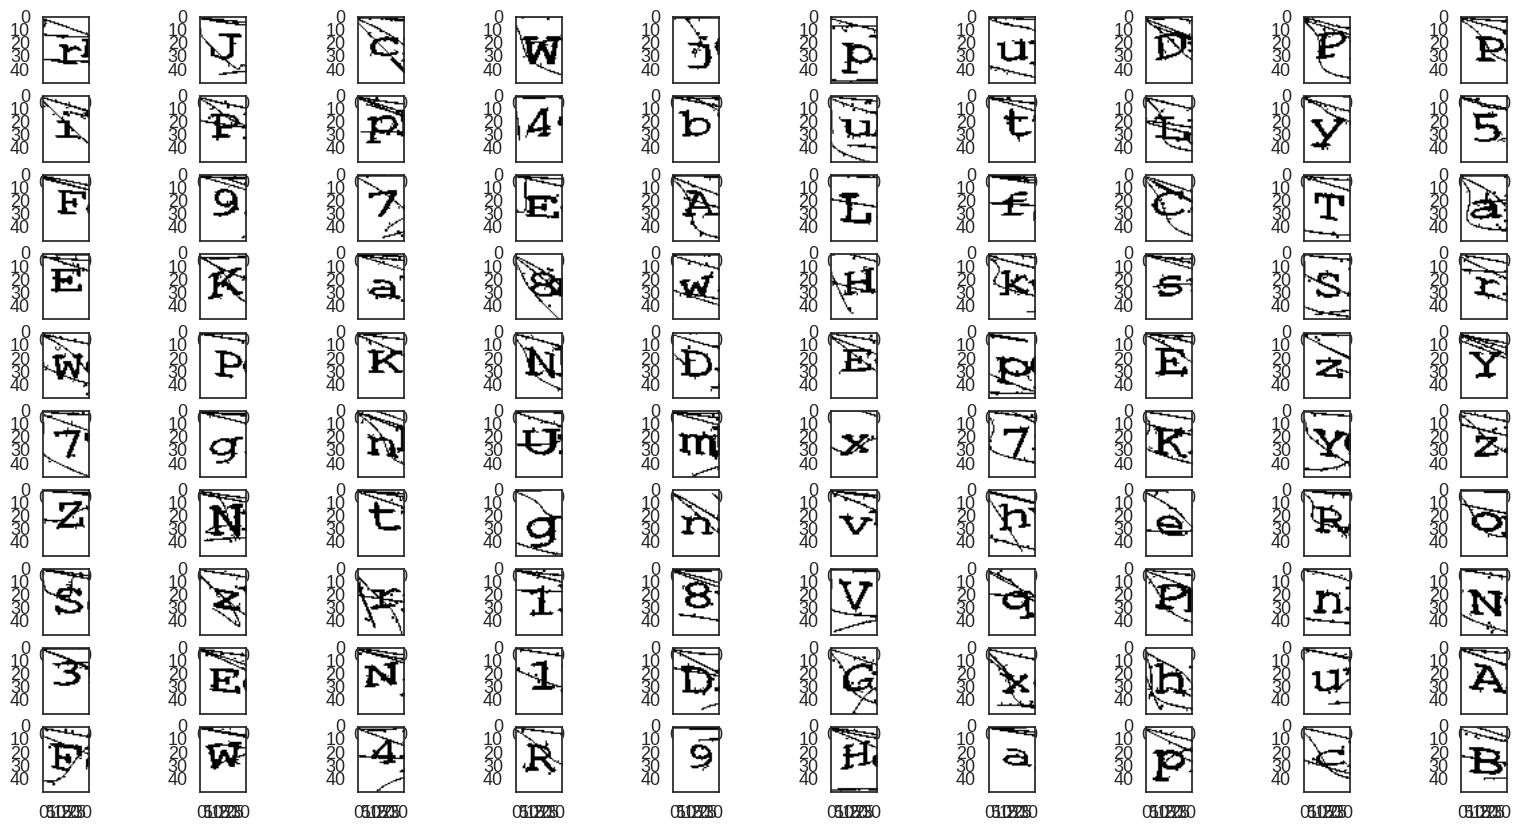

In [41]:
# 1º caractere
cropped = [get_char(img, 0) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [42]:
letters = ('r', 'J', 'c', 'W', 'j', 'p', 'u', 'D', 'P', 'P',
          'i', 'p', 'p', '4', 'b', 'u', 't', 'L', 'y', '5',
          'F', '9', '7', 'E', 'A', 'L', 'f', 'C', 'T', 'a',
          'E', 'K', 'a', '8', 'w', 'H', 'k', 's', 'S', 'r',
          'W', 'P', 'K', 'N', 'D', 'E', 'p', 'E', 'z', 'Y',
          '7', 'g', 'n', 'U', 'm', 'x', '7', 'K', 'Y', 'z',
          'Z', 'N', 't', 'g', 'n', 'v', 'h', 'e', 'R', 'o',
          'S', 'z', 'r', '1', '8', 'V', 'q', 'P', 'n', 'N',
          '3', 'E', 'N', '1', 'D', 'G', 'x', 'h', 'u', 'A',
          'F', 'w', '4', 'R', '9', 'H', 'a', 'p', 'c', 'B')

feed_char_dict(captcha_letters, letters, cropped)

# Salvar base de dados de Letras

In [43]:
save_images(captcha_letters)

---------------------------------
# Aplicação de comparação entre imagens

In [ ]:
compare_images(unblobbed[0], unblobbed[0], "two captchas")

In [ ]:
compare_images(captcha_letters['w'][0], captcha_letters['w'][1], "two W's")

In [ ]:
compare_images(captcha_letters['9'][0], captcha_letters['9'][1], "two 9's")

In [ ]:
compare_images(captcha_letters['g'][0], captcha_letters['9'][1], "two differents")